In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

In [3]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import albumentations as A
import cv2
from glob import glob
from tqdm import tqdm
import numpy as np

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)


def augment_data(read_path, save_path, category = None, augment=True):
    """ Performing data augmentation. """
    #H = 80
    #W = 80

    for img in os.listdir(read_path):
        """ Extracting the dir name and image name """

        image_path = os.path.join(read_path,img)
        name = img.split(".jpg")[0]
        #print(image_path)


        """ Read the image """
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)

        augmentation_pipeline = A.Compose([

            # Geometric Transformations
            A.HorizontalFlip(p=0.5),  # 50% chance of flipping the image left-right
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),  # Slight shift, scale, rotate

            # Elastic Deformation (Slight)
            A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Mild elastic deformation

            # Brightness and Contrast Adjustments
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast

            # Adding Noise
            A.GaussianBlur(blur_limit=(3, 5), p=0.5),  # Slight Gaussian blur
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  # Add Gaussian noise

            # Cutout/CoarseDropout
            A.CoarseDropout(max_holes=3, max_height=4, max_width=4, min_holes=3, min_height=4, min_width=4, p=0.3)  # Drop random parts

            # Distortions
            #A.GridDistortion(p=0.3),  # Slight grid distortion
            #A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3),  # Slight optical distortion

            # Padding and Cropping
            #A.PadIfNeeded(min_height=224, min_width=224, p=1.0),
            #A.RandomCrop(height=224, width=224, p=1.0)  # Randomly crop the image to 224x224
            ])

        X = [x]


        if (augment == True) and category == 'ship':

            for _ in range(11):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])

        elif (augment == True) and category == 'Noship':

            for _ in range(3):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])


        idx = 0
        for i in X:
            #i = cv2.resize(i, (W, H))

            if len(X) == 1:  # each loop it will take one image
                tmp_image_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{idx}.jpg"

            image_path = os.path.join(save_path, tmp_image_name)

            cv2.imwrite(image_path, i)

            idx = idx + 1
        #break

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
data_path = "/content/drive/MyDrive/ShipNet/shipsnet"

files = os.listdir(data_path)

print(len(files))

4000


In [5]:
create_dir('new_data/train/ship')
create_dir('new_data/train/nonship')
create_dir('new_data/val/ship')
create_dir('new_data/val/nonship')
create_dir('new_data/test/ship')
create_dir('new_data/test/nonship')

In [6]:
ships = []
nonships = []

for _ in files:
  category = float(_.split("__")[0])
  if category == 0 :
    nonships.append(_)
  else:
    ships.append(_)

In [7]:
print(len(ships))
print(len(nonships))

1000
3000


In [8]:
import random
np.random.seed(42)
test_size = 0.2

test_of_ships = random.sample(range(0, len(ships)), int(test_size*len(ships)))
test_of_nonships = random.sample(range(0, len(nonships)), int(test_size*len(nonships)))

available_numbers_for_ships = [num for num in range(0, len(ships)) if num not in test_of_ships]
available_numbers_for_nonships = [num for num in range(0, len(nonships)) if num not in test_of_nonships]

valid_of_ships = random.sample(available_numbers_for_ships, int(test_size*len(available_numbers_for_ships)))
valid_of_nonships = random.sample(available_numbers_for_nonships, int(test_size*len(available_numbers_for_nonships)))

train_of_ships = [num for num in available_numbers_for_ships if num not in valid_of_ships]
train_of_nonships = [num for num in available_numbers_for_nonships if num not in valid_of_nonships]

In [9]:
print(len(test_of_nonships))
print(len(valid_of_nonships))
print(len(train_of_nonships))

print(len(test_of_ships))
print(len(valid_of_ships))
print(len(train_of_ships))

600
480
1920
200
160
640


In [10]:
def move_images(idx_list,read_path,write_path,data):
    for idx in idx_list:
        image_path = os.path.join(read_path,data[idx])
        name = data[idx].split(".png")[0]
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)

        tmp_image_name = f"{name}.jpg"
        image_write_path = os.path.join(write_path, tmp_image_name)
        cv2.imwrite(image_write_path, x)

In [11]:
move_images(test_of_nonships,data_path,'new_data/test/nonship',nonships)
move_images(test_of_ships,data_path,'new_data/test/ship',ships)

In [12]:
move_images(valid_of_ships,data_path,'new_data/val/ship',ships)
move_images(valid_of_nonships,data_path,'new_data/val/nonship',nonships)

In [13]:
move_images(train_of_nonships,data_path,'new_data/train/nonship',nonships)
move_images(train_of_ships,data_path,'new_data/train/ship',ships)

In [14]:
print(len(os.listdir('new_data/test/nonship')),
len(os.listdir('new_data/test/ship')),
len(os.listdir('new_data/val/nonship')),
len(os.listdir('new_data/val/ship')),
len(os.listdir('new_data/train/nonship')),
len(os.listdir('new_data/train/ship')))

600 200 480 160 1920 640


In [15]:
create_dir('new_data/aug_train/ship')
create_dir('new_data/aug_train/nonship')

In [16]:
augment_data('new_data/train/ship','new_data/aug_train/ship',category = 'ship',augment=True)
augment_data('new_data/train/nonship','new_data/aug_train/nonship',category = 'Noship',augment=True)

In [17]:
print(len(os.listdir('new_data/aug_train/nonship')),
len(os.listdir('new_data/aug_train/ship')))

7680 7680


In [18]:
train_path = r'new_data/aug_train/'
test_path = r'new_data/test/'
val_path = r'new_data/val'


train_datagen = ImageDataGenerator(rescale = 1/255.0)

val_datagen = ImageDataGenerator(rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale = 1/255.0)



train_batches = train_datagen.flow_from_directory(directory = train_path,
                target_size = (80,80), batch_size = 32, shuffle=True)

valid_batches = val_datagen.flow_from_directory(directory = val_path,
                target_size = (80,80), batch_size = 32, shuffle=False)

test_batches = test_datagen.flow_from_directory(directory = test_path,
                target_size = (80,80), batch_size = 32, shuffle=False)

Found 15360 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [19]:
base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(80,80,3),
                   include_top=False,
                   weights="imagenet")
base_model.summary()

<ipython-input-19-000ef5a49bb7>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(80,80,3),


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 40, 40, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 40, 40, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 40, 40, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 40, 40, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 20, 20, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 20, 20, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 20, 20, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 20, 20, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 20, 20, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [20]:
#x = base_model.layers[-38].output
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

In [21]:
model = Model(inputs=base_model.input, outputs=output)

In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 80, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 40, 40, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 40, 40, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 40, 40, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 40, 40, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 40, 40, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 40, 40, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 41, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 20, 20, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 20, 20, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 20, 20, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 20, 20, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 20, 20, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 20, 20, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,364,898 (12.84 MB)

 Trainable params: 3,342,690 (12.75 MB)

 Non-trainable params: 22,208 (86.75 KB)

In [24]:
# Define a custom learning rate decay function
def exponential_decay(epoch, lr):
    decay_rate = 0.9  # Decay by 4% each epoch
    return lr * decay_rate

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_decay)

In [25]:
history = model.fit(x = train_batches,
          validation_data = valid_batches,
          callbacks=[lr_callback],
          epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


480/480 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - accuracy: 0.7585 - loss: 0.5657 - val_accuracy: 0.9766 - val_loss: 0.0634 - learning_rate: 9.0000e-05
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9521 - loss: 0.1353 - val_accuracy: 0.9937 - val_loss: 0.0260 - learning_rate: 8.1000e-05
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9729 - loss: 0.0788 - val_accuracy: 0.9937 - val_loss: 0.0209 - learning_rate: 7.2900e-05
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9820 - loss: 0.0555 - val_accuracy: 0.9937 - val_loss: 0.0206 - learning_rate: 6.5610e-05
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9883 - loss: 0.0446 - val_accuracy: 0.9953 - val_loss: 0.0127 - learning_rate: 5.9049e-05
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9890 - loss: 0.0413 - val_accuracy: 0.9969 - val_loss: 0.0084 - learning_rate: 5.3144e-05
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accurac

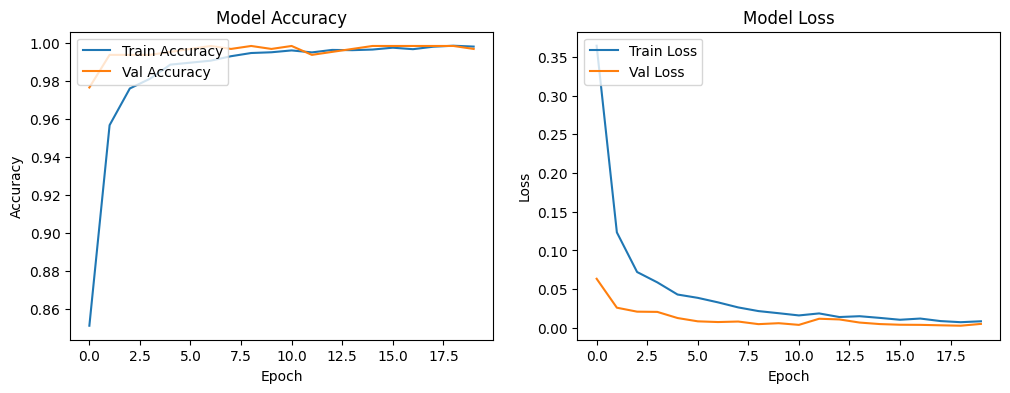

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [27]:
test_labels = test_batches.classes
len(test_labels)

800

In [28]:
preds = model.predict(x=test_batches,verbose=0)

In [29]:
cm = confusion_matrix(y_true = test_labels, y_pred = preds.argmax(axis=1))
cm

array([[598,   2],
       [  0, 200]])

In [30]:
loss, accuracy = model.evaluate(test_batches)
print(f'Loss: {loss}, Accuracy: {accuracy}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9985 - loss: 0.0020
Loss: 0.0035059740766882896, Accuracy: 0.9975000023841858


In [31]:
model.save('/content/drive/MyDrive/ShipNet/best_model.keras')

In [48]:
def sliding_window(image, window_size, stride):
    """
    Generator function to yield sliding window patches from the image.
    Args:
    - image: Input image (numpy array).
    - window_size: Tuple (height, width) of the sliding window.
    - stride: Step size for sliding window.
    Yields:
    - x: Top-left x coordinate of the window.
    - y: Top-left y coordinate of the window.
    - window: Image patch of size window_size.
    """
    for y in range(0, image.shape[0] - window_size[0] + 1, stride):
        #print(y)
        for x in range(0, image.shape[1] - window_size[1] + 1, stride):
            window = image[y:y + window_size[0], x:x + window_size[1]]
            yield x, y, window



def non_maximum_suppression(detections, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to filter overlapping bounding boxes.
    Args:
    - detections: List of detected bounding boxes with scores [(x, y, w, h, score)].
    - iou_threshold: IoU threshold to filter overlapping boxes.
    Returns:
    - filtered_detections: List of filtered bounding boxes [(x, y, w, h, score)].
    """
    if len(detections) == 0:
        return []

    # Convert detections to numpy array for easier processing
    detections = np.array(detections)
    x1, y1, w, h, scores = detections[:, 0], detections[:, 1], detections[:, 2], detections[:, 3], detections[:, 4]
    x2, y2 = x1 + w, y1 + h

    # Compute areas of each box
    areas = w * h

    # Sort by confidence scores in descending order
    order = scores.argsort()[::-1]

    filtered_detections = []
    while len(order) > 0:
        i = order[0]  # Index of the box with the highest score
        filtered_detections.append(detections[i])

        # Compute IoU between the highest-score box and the rest
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # Compute the width and height of the intersection
        inter_w = np.maximum(0, xx2 - xx1)
        inter_h = np.maximum(0, yy2 - yy1)
        intersection = inter_w * inter_h

        # Compute IoU
        iou = intersection / (areas[i] + areas[order[1:]] - intersection)

        # Filter out boxes with IoU > threshold
        order = order[1:][iou <= iou_threshold]

    return filtered_detections



def detect_ships(scene, model, window_size=(80, 80), stride=20, threshold=0.5, iou_threshold=0.5):
    """
    Detect ships in a scene using a sliding window and a trained CNN model.
    Args:
    - scene: Input scene image (numpy array).
    - model: Pre-trained TensorFlow/Keras model for ship classification.
    - window_size: Tuple (height, width) of the sliding window.
    - stride: Step size for sliding window.
    - threshold: Probability threshold for classifying as a ship.
    Returns:
    - detections: List of detected bounding boxes [(x, y, width, height)].
    """
    detections = []
    for x, y, window in sliding_window(scene, window_size, stride):
        # Preprocess the window for the CNN model
        input_window = cv2.resize(window, window_size)  # Resize if necessary
        input_window = input_window / 255.0  # Normalize pixel values
        input_window = np.expand_dims(input_window, axis=0)  # Add batch dimension

        # Predict using the model
        prediction = model.predict(input_window,verbose = 0)

        # If the prediction exceeds the threshold, record the detection
        if prediction[0][1] >= threshold:
            detections.append((x, y, window_size[1], window_size[0], prediction[0][1]))  # x, y, width, height

    # Apply Non-Maximum Suppression to filter overlapping boxes
    filtered_detections = non_maximum_suppression(detections, iou_threshold)
    return filtered_detections



# Example Usage
if __name__ == "__main__":
    # Load the scene image (example path)
    scene = cv2.imread("/content/drive/MyDrive/ShipNet/scenes/lb_4.png")
    scene = cv2.resize(scene,(2000,1600))
    stride = 20

    #scene = cv2.resize(scene, (2000, 1600))  # Ensure the scene matches specified dimensions

    # Run detection
    detections = detect_ships(scene, model, window_size=(80, 80), stride=stride, threshold=0.7, iou_threshold=0.2)


In [49]:
def visualize_detections(scene, detections):
    """
    Visualize detections by overlaying bounding boxes on the scene.
    Args:
    - scene: Input scene image (numpy array).
    - detections: List of detected bounding boxes [(x, y, width, height)].
    """
    for (x, y, w, h, score) in detections:
        x, y, w, h = int(x), int(y), int(w), int(h)
        cv2.rectangle(scene, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green boxes
        label = f"{score:.2f}"
        cv2.putText(scene, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

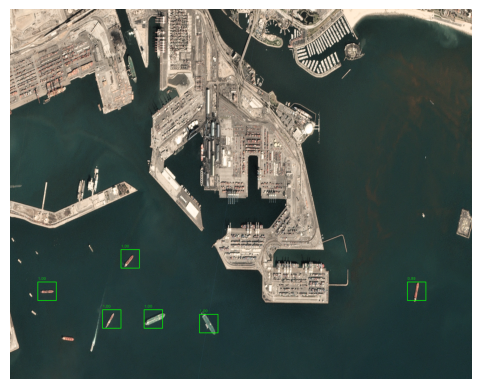

In [50]:
visualize_detections(scene, detections)

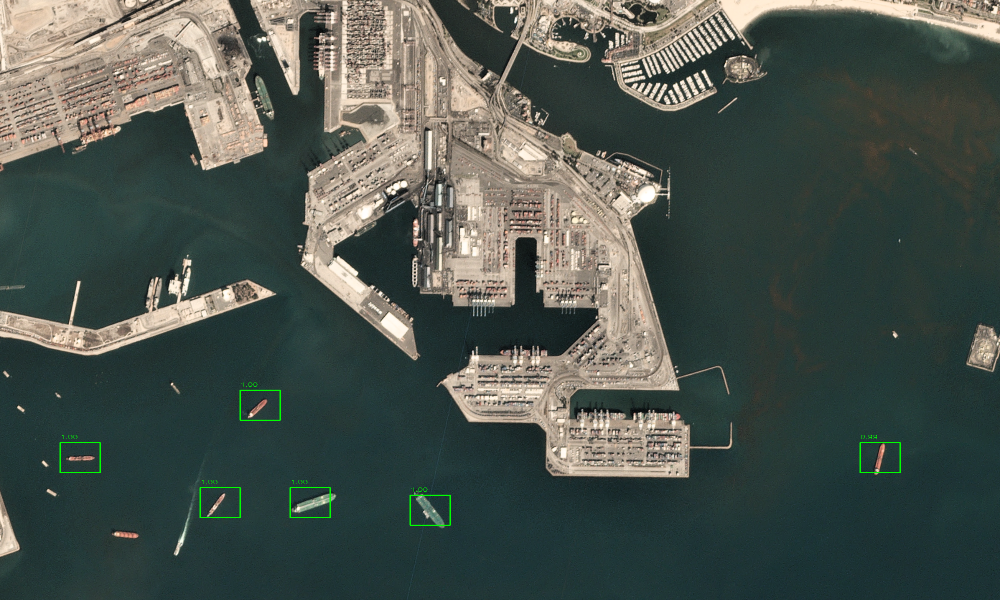

In [47]:

scene = cv2.resize(scene,(1000,600))
from google.colab.patches import cv2_imshow
cv2_imshow(scene)


In [ ]:
#model = tf.keras.models.load_model('/content/drive/MyDrive/ShipNet/best_model.keras')